<a href="https://colab.research.google.com/github/brighamfrandsen/econ484/blob/master/examples/biasvariance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Double Descent
This notebook demonstrates double descent in a least squares setting, and explores the hypothesis that double descent is a symptom of insufficient regularization. Along the way I want to verify my conjecture that the Moore-Penrose solution is identical to ridge (for any positive penalty) in the interpolation zone.

We'll generate datasets of $n$ observations, with each observation generated by the following:
$$Y_i=\sin(7x_i)\exp(-x_i^2)+\varepsilon_i,$$
where $\varepsilon_i\sim N(0,\sigma^2)$ and $x_i\sim U(-1,1)$. We will approximate the function with a Legendre polynomial series $B_k(x_i)$, which is a $k\times 1$ vector consisting of a constant and the first $k$ Legendre polynomial terms. When $n>k+1$, we will generate predictions by least squares and ridge-penalized least squares. When $n\ge k+1$ we will generate predictions by Moore-Penrose pseudo-inversion, which I conjecture is equivalent to ridge.

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import numpy.polynomial.legendre as leg
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [2]:
# define the true CEF:
def generate_expy(x):
  expy=np.sin(3*x)*np.exp(-x**2)
  return expy

def generate_legendre_matrix(x, k):
   n = x.shape[0]
   leg_matrix = np.zeros((n, k))
   for i in range(k):
       leg_matrix[:, i] = leg.Legendre.basis(i)(x.flatten())
   return leg_matrix

# generate the data, including a grid for plotting
def generate_vectors(n):
    sigma = .5
    epsilon = np.random.normal(loc=0, scale=sigma, size=(n, 1))  # Normal(0,1) variables
    x = np.random.uniform(low=-1, high=1, size=(n, 1))  # Uniform(-1,1) variables
    xgrid=np.arange(-1, 1.001, 0.001).reshape(-1, 1)
    expygrid = generate_expy(xgrid)
    y = generate_expy(x)+epsilon
    ygrid = expygrid + np.random.normal(loc=0, scale=sigma, size=(xgrid.shape[0], 1))
    return epsilon, x,y,xgrid,expygrid,ygrid

In [ ]:
n=100
epsilon, x,y,xgrid,expygrid,ygrid=generate_vectors(n)
ngrid = xgrid.shape[0]

In [ ]:
# generate legendre polynomials:
# number of terms (including constant):
kmax=150
klist = range(1,kmax+1)
# initialize place to put results:
MSEinsample = np.zeros(kmax)
MSEgrid=np.zeros(kmax)
MSEridgeinsample=np.zeros(kmax)
MSEridgeoos=np.zeros(kmax)
for k in klist:
  xpoly = generate_legendre_matrix(x,k)
  xgridpoly=generate_legendre_matrix(xgrid,k)
  # linear regression (via moore-penrose for when k>n):
  bhat = np.linalg.pinv(xpoly) @ y
  # generate in-sample predictions:
  yhat = xpoly @ bhat
  # generate predictions on grid
  yhatgrid = xgridpoly @ bhat
  # try ridge
  ridge=Ridge(alpha =1)
  ridge.fit(xpoly,y)
  yhatridge = ridge.predict(xpoly)
  yhatgridridge=ridge.predict(xgridpoly)
  MSEridgeoos[k-1]=sum((ygrid - yhatgridridge.reshape(-1,1))**2)/ngrid

  # compute MSE
  insampleterm =  sum((y-yhat)**2)/n
  MSEinsample[k-1] = insampleterm
  outofsampleterm = sum((ygrid - yhatgrid)**2)/ngrid
  MSEgrid[k-1] = outofsampleterm

<ipython-input-40-8e45ea42e2e3>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  MSEridgeoos[k-1]=sum((ygrid - yhatgridridge.reshape(-1,1))**2)/ngrid
<ipython-input-40-8e45ea42e2e3>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  MSEinsample[k-1] = insampleterm
<ipython-input-40-8e45ea42e2e3>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  MSEgrid[k-1] = outofsampleterm
<ipython-input-40-8e45ea42e2e3>:24: DeprecationWarning: Conversion of an array with ndim > 

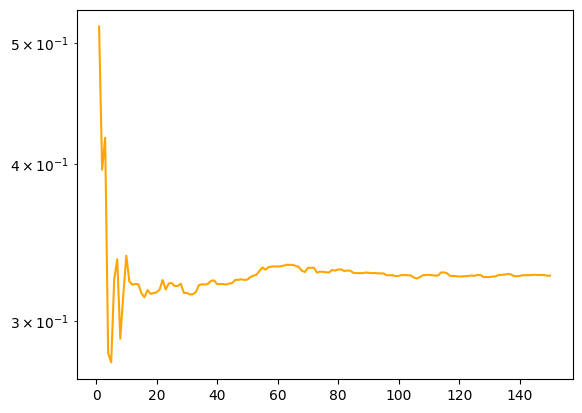

In [ ]:
#plt.plot(klist,MSEinsample,label='MSE in sample',color='red')
#plt.plot(klist,MSEgrid,label='MSE out of sample',color='blue')
plt.plot(klist,MSEridgeoos,label='MSE ridge out of sample',color='orange')
plt.yscale('log')
plt.show()



In [3]:
# want to try some stuff
n=10
epsilon, x,y,xgrid,expygrid,ygrid=generate_vectors(n)
ngrid = xgrid.shape[0]


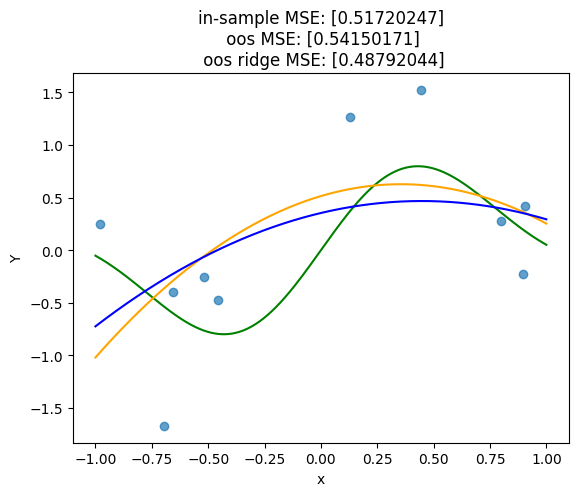

In [6]:
k = 3
xpoly = generate_legendre_matrix(x,k)
xgridpoly=generate_legendre_matrix(xgrid,k)
# linear regression (via moore-penrose for when k>n):
bhat = np.linalg.pinv(xpoly) @ y
# generate in-sample predictions:
yhat = xpoly @ bhat
# generate predictions on grid
yhatgrid = xgridpoly @ bhat

# try ridge
ridge=Ridge(alpha =1)
ridge.fit(xpoly,y)
yhatridge = ridge.predict(xpoly)
yhatgridridge=ridge.predict(xgridpoly)

MSEinsample=sum((y-yhat)**2)/n
MSEridgeinsample=sum((y-yhatridge)**2)/n
MSEoos=sum((ygrid - yhatgrid)**2)/ngrid
MSEridgeoos=sum((ygrid - yhatgridridge.reshape(-1,1))**2)/ngrid
plt.scatter(x, y, alpha=0.7)
plt.plot(xgrid,expygrid,color='green')
plt.plot(xgrid,yhatgrid,color='orange')
plt.plot(xgrid,yhatgridridge,color='blue')
plt.xlabel("x")
plt.ylabel("Y")
plt.title(f"in-sample MSE: {MSEinsample}\n oos MSE: {MSEoos}\n oos ridge MSE: {MSEridgeoos}")

plt.show()

In [ ]:
yhatgridridge.reshape(-1,1)

array([[-1.40657602],
       [-1.3461431 ],
       [-1.28948911],
       ...,
       [ 0.38596812],
       [ 0.40564151],
       [ 0.42749701]])